# Constructing DNA Along a Protein Filament


This tutorial demonstrates how to construct DNA structures along a protein filament, specifically focusing on the lateral H-NS filament assembly process. This technique involves modeling interactions between DNA and protein structures, providing a method to visualize complex biological assemblies.

## Scientific Context:
- The process starts with a H-NS decamer homodimer, which serves as the initial protein scaffold.
- Four DNA Binding Domains (DBD) are fitted with 12 bp DNA strands using the H-NS DNA complex structures from previous studies (PDB: 1HNS).
- The reference frames of the 4 DNA oligomers are then used as control points to generate new DNA strands spanning the complete H-NS filament.

## Objective:
- Highlight the capability of the `.make()` function to create DNA structures by using anchor points of specific domains as control points.
- Demonstrate the flexibility of structure generation where the protein filament serves as a scaffold, enabling the generation of a DNA configuration along a reference structure.

## Steps Covered:
- Retrieve and process the trajectory object to identify DNA chains.
- Calculate control points based on the reference frames of identified DNA segments and the scientific model.
- Generate DNA along these control points and integrate with the protein structure.
- Visualize and save the new combined structure.


In [40]:
# Load necessary libraries and retrieve the trajectory object
import mdtraj as md
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import mdna

sys.path.append('./modules/')
from filament import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load MD data

### Optional full dataset download (Figshare)

`filament_minimal` is bundled and used by default in this tutorial.
`filament_dataset` is optional and only needed for full-trajectory mode.

If you do not have the full dataset yet, run:

```bash
export MDNA_FILAMENT_DATASET_URL='https://doi.org/10.6084/m9.figshare.31423193'
python ./scripts/fetch_filament_dataset.py --output-root ./data
```

The fetch script accepts DOI/landing-page URLs and resolves the direct Figshare download automatically.

Optional integrity check (only if you know the real archive hash):

```bash
export MDNA_FILAMENT_DATASET_SHA256='<REAL_SHA256>'
python ./scripts/fetch_filament_dataset.py --output-root ./data --force
```

After download, full data will be available at `./data/filament_dataset/`.

In [41]:
# Load MD data (`filament_minimal` is bundled; set to False to use full trajectories)
minimal_mode = False
minimal_dir = './data/filament_minimal/'

if not minimal_mode:
    # Load H-NS s1s1 dimers
    loc_dimers = './data/filament_dataset/0_s1s1/'
    short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc', top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
    s1s1 = md.join(short_trajs)

    # Load H-NS s2s2 dimers
    loc_dimers = './data/filament_dataset/1_s2s2/'
    short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc', top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
    s2s2 = md.join(short_trajs)

    # Load H-NS dbd to DNA complex
    loc_dbd = './data/filament_dataset/FI/'
    traj = [md.load(loc_dbd+f'dry_{i}.xtc', top=loc_dbd+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
    dna_complex = md.join(traj)

In [42]:
from pathlib import Path

if not minimal_mode and not Path('./data/filament_dataset').exists():
    print('Full dataset not found.')
    print('Minimal mode is bundled and available at ./data/filament_minimal/.')
    print('Optional download for full mode:')
    print("  export MDNA_FILAMENT_DATASET_URL='https://doi.org/10.6084/m9.figshare.31423193'")
    print('  python ./scripts/fetch_filament_dataset.py --output-root ./data')
    print('Optional checksum verification (real hash only):')
    print("  export MDNA_FILAMENT_DATASET_SHA256='<REAL_SHA256>'")

In [43]:
if not minimal_mode:
    view = nv.show_mdtraj(dna_complex)
    view
else:
    print('Minimal mode enabled: skipping full dataset preview cell.')

In [44]:
# Define segments of the protein
n = 2  # Overlap of residues between segments

segments = {
    's1': np.arange(0, 41 + n),
    'h3': np.arange(41 - n, 53 + n),
    's2': np.arange(53 - n, 82 + n),
    'l2': np.arange(82 - n, 95 + n),
    'dbd': np.arange(95 - n, 137),
}

if minimal_mode:
    site_map = Assembler.load_minimal_site_map(minimal_dir=minimal_dir, segments=segments, n_overlap=n)
else:
    # Site map contains a dictionary with the (sub)trajectories of different sites
    mapper = SiteMapper(s1s1, s2s2, segments=segments, k=100)
    site_map = mapper.get_site_map()
    site_map['complex'] = dna_complex

### Construct H-NS filament

In [45]:
# Parameters to make filament
n_dimers = 6
chains_to_dna = [0, 4, 7, 11]
save = True

# Initialize class to assemble the filament
assembler = Assembler(site_map=site_map)
segment_mode = 'minimal' if minimal_mode else 'fixed' # Other options is 'random' if full trajectories are available

# Add dimers
print(f'Assembling {n_dimers} H-NS dimers:')
for idx in tqdm(range(n_dimers)):
    assembler.add_dimer(segment=segment_mode, verbose=True)

# Add DNA oligo's
n_dna = len(chains_to_dna)
if n_dna > 0:
    print(f"Assembling {n_dna} DNA oligo's:")
    for chainid in tqdm(chains_to_dna):
        assembler.add_dna(chainid=chainid)

# Retrieve the trajectory from the assembled complex
traj = assembler.get_traj()

Assembling 6 H-NS dimers:


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Assembling 4 DNA oligo's:


100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


### Analyze filament

Identify chains associated with DNA based on residue names typical for DNA nucleotides

In [46]:
DNA_residue_names = ['DG','DC','DT','DA']
DNA_chainids = []
for chain in traj.top.chains:
    for res in chain._residues:
        if str(res.name) in DNA_residue_names:
            DNA_chainids.append(res.chain.index)
DNA_chainids = np.unique(DNA_chainids)
DNA_chainids = np.array([DNA_chainids[i:i + 2] for i in range(0, len(DNA_chainids), 2)])


Calculate specific control points based on the center of mass and other structural features of identified DNA segments
This follows the previously described scientific model for assembling H-NS filaments

In [47]:
COM_primes = []
idx = 0
for chainids in DNA_chainids:
    nuc = mdna.load(traj, chainids=chainids)
    frames = nuc.get_frames()

    # Adding control points based on the specific arrangements in the filament model
    if idx == 0:
        COM_primes.append(frames[0][0][0] - np.array([3, -1, 0]))
        COM_primes.append(frames[0][0][0])
    elif idx == 3:
        COM_primes.append(frames[-1][0][0] + np.array([0, -2, 0]))
        COM_primes.append(frames[-1][0][0] + np.array([10, -3, 0]))
    else:
        COM_primes.append(frames[6][0][0])
    idx += 1

COM_primes = np.array(COM_primes)
points = COM_primes


### Generate DNA along filement

Generate the DNA along defined control points and integrate with the protein structure
This step visualizes the flexibility and utility of the .make() function in creating specified DNA shapes

Random sequence: GTGTCTCCACCCATTCGTTCGGTCATATGTCGTGGACAGGCGCTCTGGGGAACGGGCCTCACTGTTGACCTAGGGATTGAATTGGCTTGAAGTTGCTGCGTAATGCGAAAGCGCACAGTGAAAACGTGGGCAGTATTGTAATTATTCTCTAGTCCAATACACAATATACCCTCTCCAGACACGTTTACAATGCAATCTTAGGGCACGTCGTC 



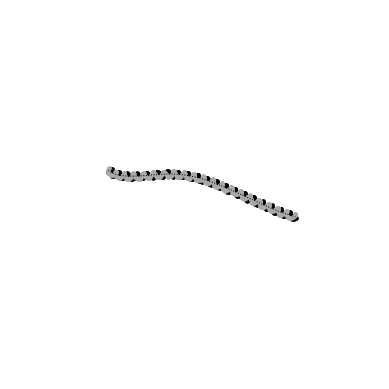

In [48]:
dna = mdna.make(control_points=points)
dna.draw()

Save result

In [49]:
# Save the structures for further analysis
dna_traj = dna.get_traj()
protein = traj.atom_slice(traj.top.select('protein'))
protein.save('./pdbs/lateral_filament_unoptimized_noDNA.pdb')
new_traj = dna_traj.stack(protein)
new_traj.save('./pdbs/lateral_filament_unoptimized.pdb')

# Visualize the final combined structure
view = nv.show_mdtraj(new_traj)
view

NGLWidget()